MIDA Gondara and Wang(2018) in Python (using PyTorch)
https://arxiv.org/abs/1705.02737
https://gist.github.com/lgondara/18387c5f4d745673e9ca8e23f3d7ebd3 

# 1. Loading Dataset

## 1.1. Load a dataset and introduce missingness

Dataset used: Shuttle Dataset (https://archive.ics.uci.edu/ml/datasets/Statlog+(Shuttle)

### 1.1.1. Load the dataset and store it as dataframe(numeric)

In [9]:
import pandas as pd
import utils

In [ ]:
#Test
filename = "data/shuttle/shuttle_trn"
df = utils.get_dataframe_from_csv(filename).iloc[:,:-1]  #remove label

In [ ]:
# #Test
# filename = "data/shuttle/shuttle_trn_debug"
# train_df = utils.get_dataframe_from_csv(filename).iloc[:,:-1]  #remove label

In [ ]:
df.head()

### 1.1.2. Inducing missingness

After dataset loading, start with inducing missingness. 

To start off, introduce simple random missing patterns (Missing Completely At Random), i.e. sample half of the variables and set observations in those variables to missing if an appended random uniform vector has value less than a certain threshhold. WIth threshold of 0.2, the procedure should introduce about 20% missingness.

In [ ]:
#test
df1 = df[:]
df2 = utils.induce_missingness(df1,logger_level=20)

In [ ]:
df1.head()

In [ ]:
df2.head()

### 1.1.3. Create Train-Test split

Create 70% training data and 30%  test data which includes missingness and a test data without missingness so we can calculate performance. 

In [ ]:
#Test
train_df, test_df, full_test_df = utils.create_train_test_split(dataframe=df1, test_perc=0.3, logger_level=20)
print(train_df.head())
print(test_df.head())
print(full_test_df.head())

# 2. Modelling

Proceed to modelling.

In R:
Start with initializing 'h2o' package and then reading the training and test datasets as the 'h2o's supported format.
Then run imputation model multiple times as each new start would initialize the weights with different values.<br>
Info at: <br>
[h2o](https://cran.r-project.org/web/packages/h2o/h2o.pdf) package offers an easy to use function for implementing autoencoders. 
More information is available at this [link](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/booklets/DeepLearningBooklet.pdf).

In Python: Using PyTorch to create the DAE, and train using the Adam optimizer from PyTorch

In [ ]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.functional as F

In [ ]:
#Settings for device, randomization seed, default tensor type, kwargs for memory #DevSeedTensKwargs
RANDOM_SEED = 18
np.random.seed(RANDOM_SEED)

if torch.cuda.is_available():
    device = 'cuda'
    torch.cuda.manual_seed(RANDOM_SEED)
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
    kwargs = {'num_workers':4, 'pin_memory' :True}
else:
    device = 'cpu'
    torch.manual_seed(RANDOM_SEED)
    torch.set_default_tensor_type(torch.FloatTensor)
    kwards = {}

In [ ]:
import dataset_module

In [ ]:
trainset = dataset_module.DataSetForImputation(train_df, normalize=True)  #normalize True for [0,1] normalization for dataframe

In [ ]:
len(trainset)

In [ ]:
import Modelling
net = Modelling.DenoisingAutoEncoder(len(trainset.variables()))

In [ ]:
net

# 3. Training

In [ ]:
import torch.utils.data as td
from torch.optim import Adam

LR = 1e-3
DATAPOINTS = len(trainset) 
BATCH_SIZE = 512 
BATCHES = DATAPOINTS/BATCH_SIZE
VARIABLES  = len(trainset.variables()) #9


import Modelling
net = Modelling.DenoisingAutoEncoder(len(trainset.variables()), theta = 7, input_dropout=0.5)

criterion = nn.MSELoss()
net = net.to(device) 

trainset = dataset_module.DataSetForImputation(train_df, normalize=True)
# testset = dataset_module.DataSetForImputation(test_df, normalize=True)

train_loader = td.DataLoader(trainset, batch_size= BATCH_SIZE, shuffle= True, **kwargs) 

optimizer = Adam(net.parameters(), lr = LR)

LOG_INTERVAL = 10
SAVE_INTERVAL = 50
torch.set_printoptions(sci_mode=False)

In [ ]:
'''
TO DO:
:- Nesterov Momentum + Adam- Pytorch? Decay factor?
'''
import os
from tqdm import tqdm_notebook as tqdm
def train_model(start_steps = 0, end_steps = 5, net=None, model_name = "DAE_Arch_N_7_ImputeOnlyNaNs_WithDropout", logger_level = 20):
    import logging
    logger = logging.getLogger()
    logger.setLevel(logger_level)

    NaN_flag = False
    
    for epoch in tqdm(range(start_steps, end_steps)):
        count = epoch-start_steps+1
        net.train()
        #Epoch begins
        epoch_loss = 0.0
        for x, d in tqdm(train_loader):
            # Normalize between [0,1] for better convergence 
            original_x = x
            x[torch.isnan(x)]=0   #If an entire column is zero, division by 0, replace NaNs with zero
            d[torch.isnan(d)]=0 

            optimizer.zero_grad()
            x = x.to(device)
            with torch.no_grad():
                d = d.to(device)
            y = net(x)
            loss = torch.sqrt(criterion(y, d))   #RMSE Loss   
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            
            #Break if NaN encountered
            if torch.isnan(loss) or torch.isinf(loss):
                logging.info(f"Loss value: {loss.item()}")
                logging.info("NaN/inf occured at:")
                logging.info(f"{x}\n")
                logging.info(f"{d}\n")
                logging.info(f"Original x was : {original_x}")
                NaN_flag = True
                break

            logging.debug(f"Count: {count}, Loss :{loss}")
            
        if NaN_flag: break   #Stop training if NaN encountered
            
        #Print to screen every few epochs    
        if count%LOG_INTERVAL == 0:
            print(f"Epoch number:{epoch} Loss: {epoch_loss:.4f}")  
            
        #Training artifacts
        if model_name not in os.listdir():
            os.makedirs(model_name+"/artifacts/saved_model/")

        #Write to loss file every epoch
        with open(model_name+"/artifacts/loss_curve",mode = 'a+') as f:
            f.write(f"Epoch_number: {epoch} Loss: {epoch_loss:.4f}\n")
        
        #Save model every few epochs
        if epoch%SAVE_INTERVAL== 0:
            torch.save(net.state_dict(),f"./{model_name}/artifacts/saved_model/model_at_epoch{epoch}")
        #Epoch Ends

In [1]:
model_name = "DAE_Arch_N_7_ImputeOnlyNaNs_WithDropout"

In [ ]:
train_model(0,50, net, model_name)

In [18]:
# '''Remove folder before training again'''
# import shutil
# shutil.rmtree(model_name)

Learning Rate annealing:- Maybe need a smaller learning rate after a while? 
Nesterov momentum:- Check paper to see if all the features have been implemented exactly (like Nesterov?)
              
Experiments to try:
1. Plot different values for different architectures.
2. Try feeding in with just the imputed values instead of the whole predicted data.
3. Try without dropout.

Features needed:

1. Printing out the denormalized data in prediction - DONE
2. Store the ids of NaNs before filling them up with placeholders - Not Needed, wrote a better TEST FUNCTION
3. Do 70/30 Split before training, testing - DONE
4. Add provision in model for changing theta params - DONE
5. Add provision for removing dropout - DONE
6. Plotting Loss function - DONE

In [ ]:
# Saving model

#torch.save(optimizer.state_dict(), filename)
#optimizer.load_state_dict(torch.load(filename))

# Modelling Loading from saved point

# model =  Modelling.DenoisingAutoEncoder(len(trainset.variables()))
# model.load_state_dict(torch.load("./artifacts/saved_model_epoch50"))
# model.eval()

In [ ]:
#Tweaking the learning rate to improve convergence speed
# optimizer = Adam(net.parameters(), LR)

# 4. Testing

In [ ]:
net = net.eval()
print((net(trainset[0][0]).detach()))
print(trainset[0][0])

In [ ]:
net = net.eval()
print(trainset.get_denormalized_data((net(trainset[0][0].detach()))))
print(trainset.get_denormalized_data(trainset[0][0]))

In [ ]:
import pandas as pd
import torch
def test_model(net=None, test_df= None, trainset=None, device =None, logger_level=20):
    """
    Function to evaluate the model on test set
    Should meet the following requirements:
        :-trainset - should be an object of class DataSetForImputation
        :-test_df - should be a Pandas dataframe with NaNs (if there are no NaNs, the same will be returned)
        :-net - should be an object of DenoisingAutoEncoder
    """
    assert isinstance(net, Modelling.DenoisingAutoEncoder)
    assert isinstance(test_df, pd.DataFrame)
    assert isinstance(trainset, dataset_module.DataSetForImputation)
    
    import logging
    logger = logging.getLogger()
    logger.setLevel(logger_level)
    
    NaN_test_df = test_df.reset_index(drop=True)  #Dropping index so that everything is reindexed from 0
       
    test_df = test_df.apply(lambda x: x.fillna(x.mean()), axis=0)
    test_df_norm = (test_df- trainset.min_df)/(trainset.max_df-trainset.min_df)
    test_df_tensor = torch.tensor(test_df_norm.values).to(device)
        
    net = net.eval()
    logging.debug(f"{test_df_tensor.shape}")
    pred = net(test_df_tensor)
     
    pred =  trainset.get_denormalized_data(pred)  #Predicted dataframe from the mode    
    
    # Replace the NaNs in the original test_df with newly imputed values
    final_pred = NaN_test_df.where(~NaN_test_df.isna(), other = pred)
    logging.debug(f"final_pred:\n {final_pred.head()}")
    
    return final_pred

In [ ]:
test_df.head()

In [ ]:
test_model(net=net, test_df=test_df, trainset=trainset, device=device,logger_level=20).head()

# 5. Plotting Loss Curve

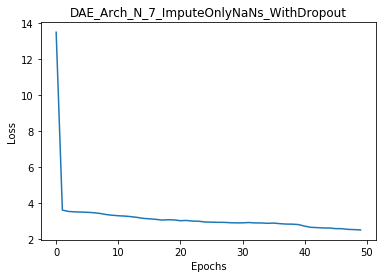

In [10]:
utils.plot_loss_curve(title=f"{model_name}")